# Semantic Segmentation

## Introduction



Semantic segmentation is the task of classifing each pixel in an image into a class. The output is a map with the same spatial dimensions of the input image having integer values from 0 to the number of classes. In the image below, there is an example taken from the KITTI Dataset. Note that for clarity, each class has been color coded.

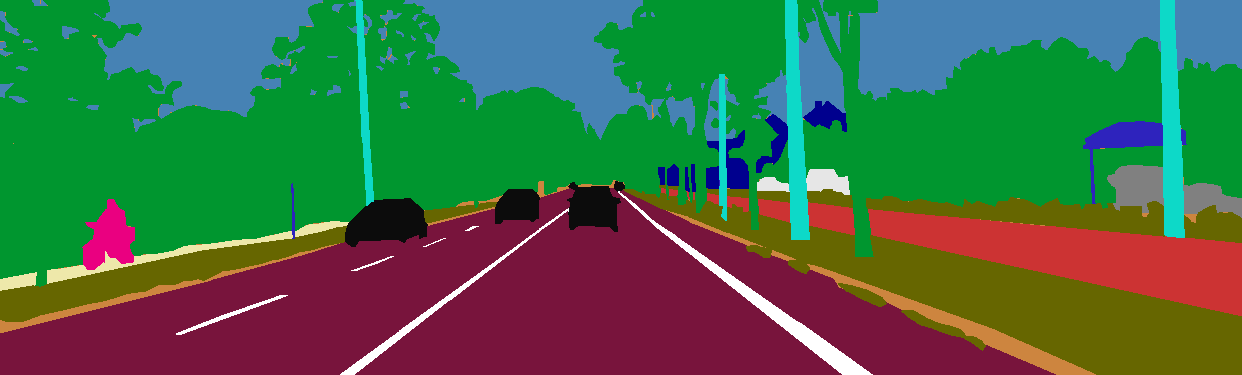

In this notebook you will learn to perform semantic segmentation through the use of a neural network.

## Instructions

The notebook is divided in parts: the dataset, the network creation, the training procedure and finally the use of the best model on a random web image. For quick access to each part, you can click on the left menu and jump to the desired code portion. In each part you will have to complete the code and the required assignments. Parts with * have a missing part that needs to be completed.

## Pre-flight installs and imports

Install latest version of tensorflow datasets, the debugger ipdb and haiku.

In [ ]:
# Install additional packages.
!pip install -q -U tfds-nightly &> /dev/null
!pip install ipdb &> /dev/null
!pip install git+https://github.com/deepmind/dm-haiku &> /dev/null
!pip install git+https://github.com/deepmind/optax.git &> /dev/null

In [ ]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras import Model
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import haiku as hk
from haiku import Conv2D, BatchNorm, Conv2DTranspose
import jax
import optax
import jax.numpy as jnp
from jax import random
import tree
import functools
import pickle
from PIL import Image
import requests
from io import BytesIO

# Load the TensorBoard notebook extension and set matplotlib inline.
%load_ext tensorboard
%matplotlib inline

# Dataset

The dataset we will be using, is the [Oxford Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). It is a dataset for supevised semantic segmentation containing images of dogs. Each sample is composed of the input image and the corresponding ground-truth, the semantic layout.

In [ ]:
# Define dataset variables.
BATCH_SIZE = 200  # @param
N_CLASSES = 2
BUFFER_SIZE = 1000

In [ ]:
# Download dataset.
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

This function normalizes the images in range 0-1

In [ ]:
# Normalises the image between 0 and 1.
def normalize(input_image, input_mask):
    # Normalize images in range [0-1].
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # Move classes ids from range [1-3] to [0-2].
    input_mask -= 1
    # Remove contour class.
    input_mask = tf.where(input_mask == 2,
                          tf.zeros_like(input_mask),
                          input_mask)
    return input_image, input_mask

This function loads a training image and augments it with random flipping

In [ ]:
@tf.function
def load_image_train(datapoint):
    # Load image and corresponding semantic layout.
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128),
                                 method='nearest')
    # With p=0.5, augment sample.
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # Normalize the image.
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

This function loads a test image and resizes it at 128x128

In [ ]:
# Loads a test image.
def load_image_test(datapoint):
    # Load image and semantic layout.
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128),
                                 method='nearest')
    # Normalize the image.
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Define a function to perform color-coding of the semantic layout

In [ ]:
def color_coding(layout, cmap='Set1'):
    # Remove singleton dimension if exists.
    if layout.ndim == 4:
        layout = jnp.squeeze(layout, axis=-1)
    # Get the colormap.
    cmap = matplotlib.cm.get_cmap(cmap)
    # Color-code the layout.
    return cmap(layout)

The dataset is already split in train/test. Let's maintain the same structure.

In [ ]:
train = dataset['train'].map(load_image_train,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

Set the use of a cache of size BUFFER_SIZE, shuffle the samples, set the batch size and finally make the iterator infinite.

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's now take a look at an image and the corresponding semantic segmentation layer.

In [ ]:
# Get a random batch.
image, segmask = train_dataset.__iter__().get_next()
image, segmask = image.numpy(), segmask.numpy()
print('The size of images is : ', image.shape)
print('The size of semlay is : ', segmask.shape)
print('The semantic layout contains values: ', jnp.unique(segmask))
# Get the first sample from the batch.
image = image[0]
segmask = segmask[0]
# Remove singleton dimension.
segmask = jnp.squeeze(segmask, axis=2)

# Create a new figure.
plt.figure(figsize=(10, 10))
# Show the input image.
plt.subplot(2, 2, 1)
plt.title('Input')
plt.imshow(image)
# Show the ground-truth.
plt.subplot(2, 2, 2)
plt.title('Ground-truth layout')
plt.imshow(color_coding(segmask))

# View the corresponding masks for each class.
labels = jax.nn.one_hot(segmask, N_CLASSES)
# Plot pixels belonging class 0.
plt.subplot(2, 2, 3)
plt.title('Mask of class 0')
plt.imshow(labels[:, :, 0], cmap='gray')
# Plot pixels belonging class 1.
plt.subplot(2, 2, 4)
plt.title('Mask of class 1')
plt.imshow(labels[:, :, 1], cmap='gray')

# Show the image.
plt.show()

# Network

The network we will use is a sequence of Downsample blocks that project the input image of size 128x128x3 in a feature space of size 4x4x512 (reaching a compression factor of 83.33%), followed by a sequence of Upsample blocks that transform the latent features in semantic layouts.

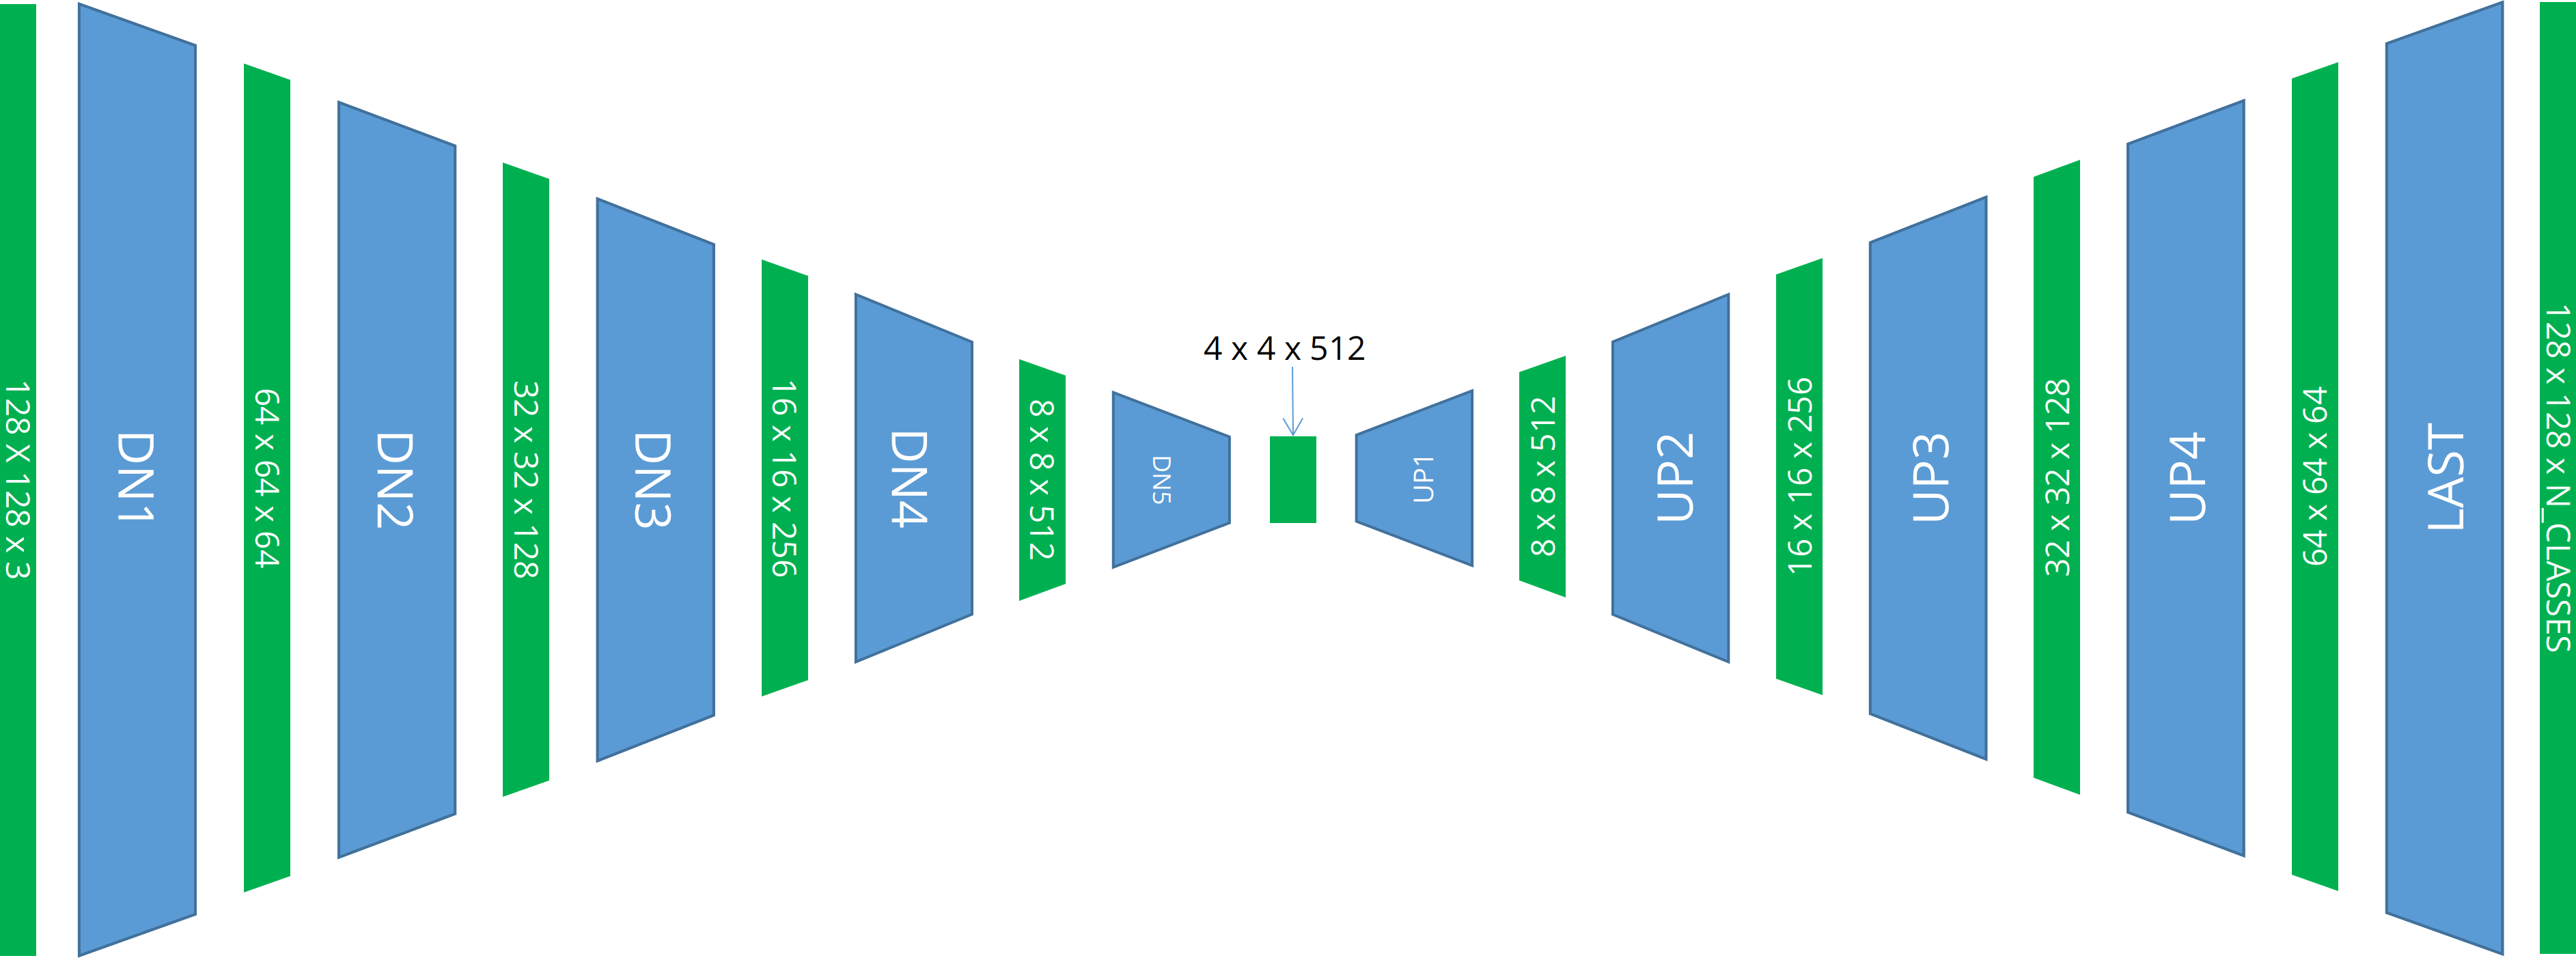

Now we will define the Downsample and the Upsample blocks, which are the basic blocks of the network.

### Downsample block *

Build the downsample block. It should be composed of:
1. a convolution with the following properties:
  - channels and size passed as input
  - stride=2
  - padding 'SAME'
  - weights init function passed as argument
  - without bias

2. a batchnorm with scale and offset, a decay rate of 0.999 and eps of 0.001 that will be applied only if the argument _apply\_batchnorm_ is True.

3. a relu.

In [ ]:
class Downsample(hk.Module):
    def __init__(self, channels, size, apply_batchnorm=True,
                 initializer=hk.initializers.RandomNormal(
                     mean=0.0, stddev=0.02)):
        super().__init__()
        # Conv layer.
        self.conv = Conv2D(channels, size, stride=2, padding="SAME",
                           w_init=initializer, with_bias=False)
        # Batch normalization.
        self.bn = None
        if apply_batchnorm:
            self.bn = BatchNorm(create_scale=True, create_offset=True,
                                decay_rate=0.999, eps=0.001)

    def __call__(self, x, is_training=True):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x, is_training)
        x = jax.nn.relu(x)
        return x

### Upsample block

In [ ]:
class Upsample(hk.Module):
    def __init__(self, channels, size,
                 initializer=hk.initializers.RandomNormal(
                     mean=0.0, stddev=0.02)):
        super().__init__()
        # Transposed conv layer.
        self.convt = Conv2DTranspose(channels, size, stride=2, padding='SAME',
                                     w_init=initializer, with_bias=False)
        # Batch normalization.
        self.bn = BatchNorm(create_scale=True, create_offset=True,
                            decay_rate=0.999, eps=0.001)

    def __call__(self, x, is_training=True):
        x = self.convt(x)
        x = self.bn(x, is_training)
        x = jax.nn.relu(x)
        return x

### Network Definition *
Build the forward pass of the network (the _call_ method of the class). Apply all blocks in sequence, from _dn1_ to _last_.

In [ ]:
class Net(hk.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Define Downsample layers.
        self.dn1 = Downsample(64, 3, apply_batchnorm=False)
        self.dn2 = Downsample(128, 3)
        self.dn3 = Downsample(256, 3)
        self.dn4 = Downsample(512, 3)
        self.dn5 = Downsample(512, 3)
        # Define Upsample layers.
        self.up1 = Upsample(512, 3)
        self.up2 = Upsample(256, 3)
        self.up3 = Upsample(128, 3)
        self.up4 = Upsample(64, 3)
        # Define last layer.
        initializer = hk.initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.last = hk.Conv2DTranspose(n_classes, 4, stride=2,
                                       padding='SAME', w_init=initializer)

    def __call__(self, x, is_training=True):
        # Get down activations.
        out_dn1 = self.dn1(x, is_training=is_training)        # (B,64,64,64)
        out_dn2 = self.dn2(out_dn1, is_training=is_training)  # (B,32,32,128)
        out_dn3 = self.dn3(out_dn2, is_training=is_training)  # (B,16,16,256)
        out_dn4 = self.dn4(out_dn3, is_training=is_training)  # (B,8,8,512)
        out_dn5 = self.dn5(out_dn4, is_training=is_training)  # (B,4,4,512)
        # Get up activations.
        out_up1 = self.up1(out_dn5, is_training=is_training)  # (B,8,8,512)
        out_up2 = self.up2(out_up1, is_training=is_training)  # (B,16,16,256)
        out_up3 = self.up3(out_up2, is_training=is_training)  # (B,32,32,128)
        out_up4 = self.up4(out_up3, is_training=is_training)  # (B,64,64,64)
        # Apply last layer.
        out = self.last(out_up4)  # (B,128,128,3)
        return out

### Network initialization

In [ ]:
# Get a random sample to initialize the network.
randsample, randsemseg = train_dataset.__iter__().get_next()
randsample = randsample.numpy()
# Convert the network to a JAX pure function.
net = hk.transform_with_state(
  lambda *args: Net(N_CLASSES)(*args)
)
# Initialize the network.
rng = jax.random.PRNGKey(42)
net_params, net_state = net.init(rng, randsample, True)

# Logging

Start the tensorboard and define the event writer.

In [ ]:
%tensorboard --logdir /content/logs

# Training

The output of the network is a set of unconstrained maps. Each pixel of these maps is a vector of size NCLASSES. The position of the highest value represents the predicted class for that pixel. If we want to get the confidence of the predictions, we firstly need to convert each vector in a probability vector (which sums to one) by applying the softmax function.

To compare the predicted maps with the ground-truth, we have to convert the ground-truth layout in a set of binary maps (one for each class) to indicate the class of each pixel. The operation of converting a semantic layout in a set of maps is called _one-hot encoding_.

On the left there is an example of output while on the right the corresponding ground truth after the _one-hot encoding_ operation.

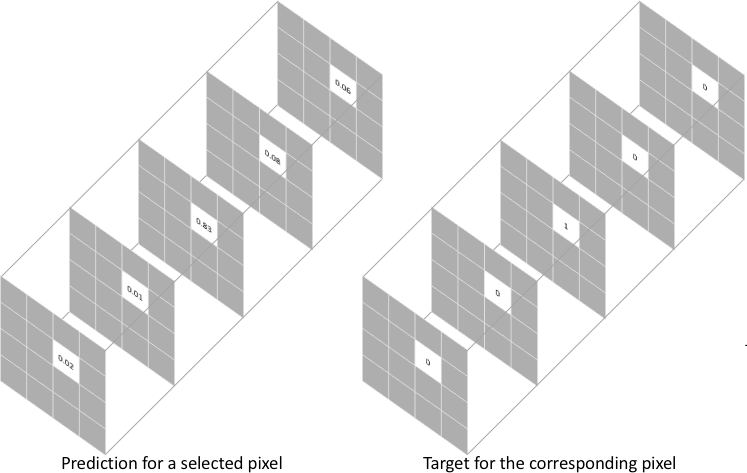




[Image credits](https://www.jeremyjordan.me/semantic-segmentation/#loss)



In [ ]:
EPOCHS = 30   # @param
LR = 1e-3  # @param
WDIR = '/content/weights'

# Create folder containing checkpoints.
os.makedirs(WDIR, exist_ok=True)

## Optimizer

In [ ]:
# Initialize the optimizer.
optimizer = optax.adam(LR)
opt_state = optimizer.init(net_params)

## Loss function *

Complete the function _loss\_function_. It has to implement these steps:
1. compute predictions
2. convert semantic layout in binary maps with the use of _jax.nn.one\_hot_ function.
3. compute the _softmax\_cross\_entropy_ loss between the prediction and the just-obtained one-hot-encoded masks.
4. average the loss to obtain a single number representing the mean loss.
5. return loss and net_state

In [ ]:
# Computes softmax cross entropy for classification.
def softmax_cross_entropy(logits, labels):
    return -jnp.sum(labels * jax.nn.log_softmax(logits), axis=-1)

# Computes the loss.
def loss_function(net_params, net_state, images, semlay):
    # Compute predictions.
    predictions, net_state = net.apply(net_params, net_state,
                                       None, images, True)
    # Convert labels to one-hot encoding.
    labels = jax.nn.one_hot(jnp.squeeze(semlay, axis=3), N_CLASSES)
    # Compute loss.
    loss = jnp.mean(softmax_cross_entropy(predictions, labels))
    return loss, net_state

## Accuracy *
Accuracy is defined as the number of correctly classified pixels over the total amount of pixels, on all the testset. 

Build the function _accuracy_:
1. get predictions on the current image _img_
2. calculate the predicted class (the index of the map with the highest value) for each pixel.
3. compare with ground truth _layout_. Same class pixels increase _correct_ accumulator.
4. Increase the total number of pixels analized in _total_ accumulator.
5. Compute the accuracy as correct / total and return it

In [ ]:
def accuracy(ds, net_params, net_state):
    correct, total = 0, 0
    for img, layout in ds:
        # Convert to numpy.
        img = img.numpy()
        layout = layout.numpy()
        # Get predictions.
        predictions, net_state = net.apply(net_params, net_state,
                                           None, img, False)
        # Get predicted classes.
        pred_semlay = jnp.argmax(predictions, axis=-1)[..., None]
        # Compare with ground truth.
        correct += (pred_semlay == layout).sum()
        total += layout.size
    acc = correct / total
    return acc

## Training step *
Create the training step.
1. Evaluate the loss and compute the gradients with the function _jax.value\_and\_grad_.
2. Perform weights optimization

In [ ]:
@jax.jit
def train_step(net_params, net_state, opt_state, images, semlay):
    # Evaluate and compute gradients.
    (loss, net_state), grads = jax.value_and_grad(loss_function, has_aux=True)(
        net_params, net_state, images, semlay)
    # Update weights.
    net_update, opt_state = optimizer.update(grads, opt_state)
    net_params = optax.apply_updates(net_params, net_update)
    return net_params, net_state, opt_state, loss

## Training loop

In [ ]:
# Create logger and set it as default.
logdir = os.path.join("/content/logs",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer = tf.summary.create_file_writer(logdir)
file_writer.set_as_default()

# Determine number of iterations for each epoch.
niters = info.splits['train'].num_examples // BATCH_SIZE

# Initialize best_acc for early stopping.
best_acc = 0

# Train loop.
for ne in range(EPOCHS):
    for i, (img, layout) in enumerate(train_dataset):
        # Convert to numpy.
        img = jnp.asarray(img)
        layout = jnp.asarray(layout)

        # Run a training step.
        net_params, net_state, opt_state, loss = \
        train_step(net_params, net_state, opt_state, img, layout)

        # Add to tensorboard.
        tf.summary.scalar('loss', data=loss, step=i + ne * niters)
        
        # Every 8 iters, print loss and show predictions.
        if i % 8 == 0:
            plt.close()
            predictions, net_state = net.apply(net_params, net_state,
                                               rng, img, False)
            pred_semlay = jnp.argmax(predictions, axis=-1)[..., None]
            # Display images in tensorboard.
            tf.summary.image("Input", img, step=i+ne*niters)
            tf.summary.image("Output", color_coding(pred_semlay),
                             step=i+ne*niters)
            tf.summary.image("Ground-truth", color_coding(layout),
                             step=i+ne*niters)
            # Print loss.
            print('[{:02d}/{:d}][{:02d}/{:d}] - '
                  'loss = {:.4f} - best_acc = {:.4f}'
                  .format(ne + 1, EPOCHS, i + 1, niters, loss, best_acc * 100))
    
    # At the end of each epoch, test accuracy.
    cur_acc = accuracy(test_dataset, net_params, net_state)
    # Save current accuracy.
    tf.summary.scalar('accuracy', data=cur_acc, step=ne)
    # Check for early stopping.
    if cur_acc > best_acc:
        # Save new best accuracy.
        best_acc = cur_acc
        # Save current model as the best model.
        with open(os.path.join(WDIR, 'best_model.pkl'), 'wb') as handle:
            pickle.dump((net_params, net_state), handle,
                        protocol=pickle.HIGHEST_PROTOCOL)
    # Save current model.
    with open(os.path.join(WDIR, str(ne) + '.pkl'), 'wb') as handle:
        pickle.dump((net_params, net_state), handle,
                    protocol=pickle.HIGHEST_PROTOCOL)

# Going online *

Now that we have a working model, let's use our best model to predict the semantic layout on a random web image. After executing the following block, try with a different image taken from internet by changing the URL.

In [ ]:
# Load the weights of the best model.
net_params, net_state = pickle.load(
    open(os.path.join(WDIR, 'best_model.pkl'), 'rb'))
# Load a random image.
url = 'https://i.insider.com/5484d9d1eab8ea3017b17' \
    'e29?width=700&format=jpeg&auto=webp'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
# Resize image to match network.
img = img.resize((128, 128), Image.ANTIALIAS)
# Convert to numpy.
img = jnp.array(img, dtype=jnp.float32)
# Set in range [0-1].
img = img / 255
# Add batch dimension.
img = img[None]

# Get prediction from the network.
predictions, net_state = net.apply(net_params, net_state, None, img, False)
# Convert to layout.
pred_semlay = jnp.argmax(predictions, axis=-1)[..., None]
# Apply color-coding to view classes.
pred_semlay = color_coding(pred_semlay)

# View image and predicted semantic layout.
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Input image')
plt.imshow(img[0])
plt.subplot(1, 2, 2)
plt.title('Predicted semantic layout')
plt.imshow(pred_semlay[0])
plt.show()

# Conclusions
In this notebook we learned how to perform semantic segmentation through the use of convolutional neural networks. To reinforce what you have learned, you can do the following homeworks.

## Homeworks

1. Modify the network to include skip connections and train the network again from scratch. Hint: to concatenate feature maps from current upsample layer to the corresponding downsample layer, use:
```
out_up1 = jnp.concatenate([out_up1, out_dn4], axis=-1)
```
Does it perform better?


2. Change the parameters of the initialization function for the weights, retrain from scratch and see if there are any differences.

